In [1]:
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import numpy as np

In [2]:
conn = psycopg2.connect('dbname=cpdp user=blaine password=postgres')
cur = conn.cursor()

In [3]:
# Create Subset view
cur.execute('''
    CREATE TEMP VIEW officer_subset AS
    SELECT o.id, o.first_name, o.last_name, o.birth_year, o.appointed_date,
          date_part('year', '2018-01-01'::DATE) - o.birth_year as estimated_age,
          ('2018-01-01'::DATE - o.appointed_date) / 365 as years_on_force,
          COUNT(a.id) as allegation_count
    FROM data_officer o
    LEFT JOIN data_officerallegation a on o.id = a.officer_id
    WHERE active = 'Yes'
        AND appointed_date BETWEEN '2000-01-01' AND '2007-12-31'
    GROUP BY o.id
    ORDER BY years_on_force DESC;
''')

In [4]:
# Create first filed settlement view
cur.execute('''
CREATE TEMP VIEW officer_first_settlement_filed AS
    SELECT o.id as officer_id, MIN(case_case.date_filed) as first_date
        FROM officer_subset o
    INNER JOIN cop_officer_map cop ON cop.officer_id = o.id
    INNER JOIN cops_casecop case_cop ON case_cop.cop_id = cop.cop_id
    INNER JOIN cases_case as case_case ON case_case.id = case_cop.case_id
    GROUP BY o.id
    ORDER BY first_date;
''')

In [5]:
# create date diff view
cur.execute('''
CREATE TEMP VIEW officer_date_diff AS
SELECT officer_allegation.id as id, (date_part('year', allegation.incident_date) - date_part('year', first_filed.first_date)) as date_diff
FROM data_officerallegation officer_allegation
INNER JOIN data_allegation allegation on allegation.id = officer_allegation.allegation_id
INNER JOIN officer_first_settlement_filed first_filed on first_filed.officer_id = officer_allegation.officer_id
WHERE officer_allegation.officer_id IN (SELECT id FROM officer_subset);
''')

In [6]:
date_diff_df = pd.read_sql_query('''
SELECT date_diff, COUNT(id) as count
FROM officer_date_diff
GROUP BY date_diff
ORDER BY date_diff;
''', con=conn)

In [18]:
date_diff_df

,date_diff,count
0,-15.0,2
1,-14.0,33
2,-13.0,49
3,-12.0,92
4,-11.0,118
5,-10.0,208
6,-9.0,261
7,-8.0,363
8,-7.0,495
9,-6.0,662


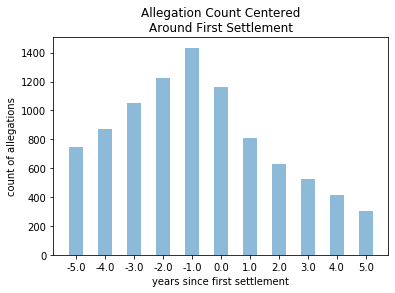

In [29]:
labels = date_diff_df['date_diff'][10:21]
y_pos = np.arange(len(labels))
data = date_diff_df['count'][10:21]
plt.bar(y_pos, data, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, labels)
plt.xlabel('years since first settlement')
plt.ylabel('count of allegations')
plt.title('Allegation Count Centered\nAround First Settlement')

plt.savefig('images/q2')